# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
import glob
import os

# 데이터 생성

5m 다항분류의 그것을 참고하여 사용한다

In [2]:
data_train = pd.read_csv("../model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model_test_data.csv", encoding="utf-8-sig")
data_predict = pd.read_csv("../model_predict_data.csv", encoding="utf-8-sig")
actor_genre = pd.read_csv("../actor_genre.csv", encoding="utf-8-sig")
director_genre = pd.read_csv("../director_genre.csv", encoding="utf-8-sig")

처음엔 배우장르 데이터면 결합해서 사용한다 - 이것도 유효한지 모르기 때문이다

## 1) 배우 장르 벡터 결합

약 15~20%의 데이터가 제거된다

In [3]:
data_train = pd.merge(data_train, actor_genre, on='Movie_Title', how='inner')
data_test = pd.merge(data_test, actor_genre, on='Movie_Title', how='inner')
data_predict = pd.merge(data_predict, actor_genre, on='Movie_Title', how='inner')

## 2) 독립, 종속 변수 분리

In [4]:
X_train = data_train.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_train_df = data_train[["Total_Audience_Count", "Total_Show_Days", "Total_Weeks"]]
X_test = data_test.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_test_df = data_test[["Total_Audience_Count", "Total_Show_Days", "Total_Weeks"]]
X_predict = data_predict.drop(columns = ["Movie_Title"])

In [5]:
print(list(X_train.columns))

['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25', 'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45', 'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'e53', 'e54', 'e55', 'e56', 'e57', 'e58', 'e59', 'e60', 'e61', 'e62', 'e63', 'e64', 'e65', 'e66', 'e67', 'e68', 'e69', 'e70', 'e71', 'e72', 'e73', 'e74', 'e75', 'e76', 'e77', 'e78', 'e79', 'e80', 'e81', 'e82', 'e83', 'e84', 'e85', 'e86', 'e87', 'e88', 'e89', 'e90', 'e91', 'e9

## 3) 수치형, 범주형변수

벡터 변수들을 제외한 것들 중

In [6]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']

## 4) 변환

In [7]:
X_train["index"] = 0
X_test["index"] = 1
X_predict["index"] = 2

X_full = pd.concat([X_train, X_test, X_predict], axis=0)

### 로그 변환

독립변수

앞서 로그변환을 하기로 결정하였다

In [8]:
log_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd']
X_full[log_cols] = np.log1p(X_full[log_cols])


### 원핫인코딩

In [9]:
X_full = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X_full.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X_full[onehot_columns] = X_full[onehot_columns].astype(int)

### 연도 변환

시간의 흐름으로 보고싶음 (시간이 지남에 따라 티켓값의 상승을 의미하므로 이리 진행해도 괜찮을 것, 정규화를 위해 변환함)

In [10]:
X_full["Year"] = X_full["Year"] - X_full["Year"].min()

### 정규화

로그변환한 데이터의 분포가 안정적이다 -> 이상치가 크게 없다  
따라서 standardscaler를 사용한다

In [11]:
scaler_standard = StandardScaler()
X_full.loc[:, num_cols]= scaler_standard.fit_transform(X_full[num_cols])

C:\Users\swoo6\AppData\Local\Temp\ipykernel_3832\3816859427.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.14727341  0.16097374 -1.64724232 ...  1.64042325  1.64042325
  1.64042325]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_full.loc[:, num_cols]= scaler_standard.fit_transform(X_full[num_cols])


In [12]:
X_train = X_full[X_full["index"] == 0].drop(columns=["index"])
X_test = X_full[X_full["index"] == 1].drop(columns=["index"])
X_predict = X_full[X_full["index"] == 2].drop(columns=["index"])

# OLS - Total_Audience_Count

In [13]:
y_train = y_train_df["Total_Audience_Count"]
y_train = np.log1p(y_train)
y_test = y_test_df["Total_Audience_Count"]
y_test = np.log1p(y_test)

## 라소, 릿지, 엘라스틱넷

In [14]:
# 라쏘
alpha_lasso = 1.0
lasso_model = Lasso(alpha=alpha_lasso, random_state=42)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
ss_res = np.sum((y_test - y_pred_lasso) ** 2)
ss_tot = np.sum((y_test - y_test.mean()) ** 2)
r_squared = 1 - ss_res / ss_tot

# 릿지
alpha_ridge = 10.0
ridge_model = Ridge(alpha=alpha_ridge, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
ss_res_ridge = np.sum((y_test - y_pred_ridge) ** 2)
ss_tot_ridge = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge = 1 - ss_res_ridge / ss_tot_ridge

# 엘라스틱넷
alpha_en = 0.1 
l1_ratio_en = 0.5
elasticnet_model = ElasticNet(alpha=alpha_en, l1_ratio=l1_ratio_en, random_state=42)
elasticnet_model.fit(X_train, y_train)
y_pred_en = elasticnet_model.predict(X_test)
mse_en = mean_squared_error(y_test, y_pred_en)
ss_res_en = np.sum((y_test - y_pred_en) ** 2)
ss_tot_en = np.sum((y_test - y_test.mean()) ** 2)
r_squared_en = 1 - ss_res_en / ss_tot_en

print("MSE (Lasso):", mse_lasso)
print("R^2 (Lasso):", r_squared)
print("MSE (Ridge):", mse_ridge)
print("R^2 (Ridge):", r_squared_ridge)
print("MSE (ElasticNet):", mse_en)
print("R^2 (ElasticNet):", r_squared_en)

MSE (Lasso): 1.1558414637907577
R^2 (Lasso): 0.6199710789646287
MSE (Ridge): 0.04114593016661226
R^2 (Ridge): 0.9864716365210401
MSE (ElasticNet): 0.06604948096405615
R^2 (ElasticNet): 0.9782836022308847


### 하이퍼파라미터 튜닝

In [15]:
alphas = np.logspace(-3, 3, 100)

In [16]:
ridge_cv = RidgeCV(
    alphas=alphas, 
    cv=5, # 5-겹 교차 검증 사용
    scoring='neg_mean_squared_error' # MSE 최소화
)
ridge_cv.fit(X_train, y_train)
y_pred_lasso = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_lasso)
ss_res_ridge_cv = np.sum((y_test - y_pred_lasso) ** 2)
ss_tot_ridge_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge_cv = 1 - ss_res_ridge_cv / ss_tot_ridge_cv
print("Optimal alpha (RidgeCV):", ridge_cv.alpha_)
print("MSE (RidgeCV):", mse_ridge_cv)
print("R^2 (RidgeCV):", r_squared_ridge_cv)

Optimal alpha (RidgeCV): 0.8111308307896873
MSE (RidgeCV): 0.03821658513749749
R^2 (RidgeCV): 0.9874347753818868


In [17]:
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5, 
    random_state=42,
    max_iter=10000 # 수렴을 위해 반복 횟수 증가
)
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
ss_res_lasso_cv = np.sum((y_test - y_pred_lasso_cv) ** 2)
ss_tot_lasso_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv.alpha_)
print("MSE (LassoCV):", mse_lasso_cv)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.001
MSE (LassoCV): 0.0382389395754336
R^2 (LassoCV): 0.9874274254699869


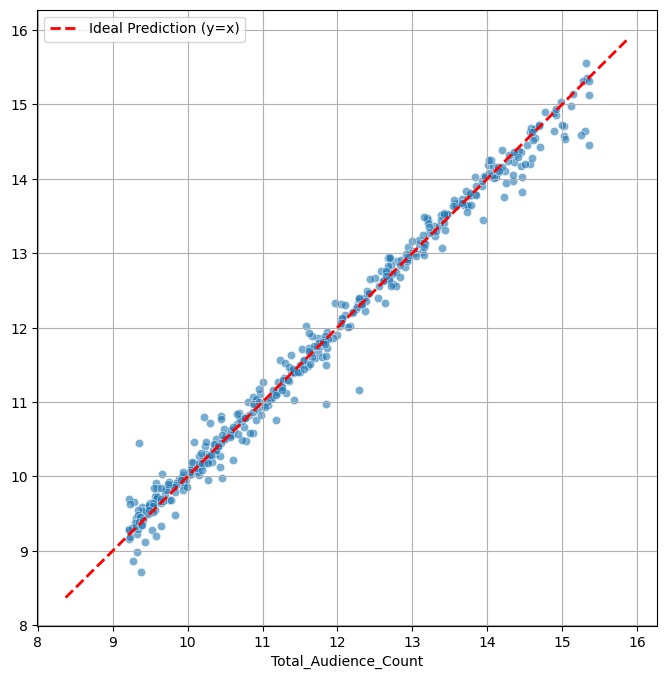

In [18]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_lasso_cv, alpha=0.6) 

min_val = min(y_test.min(), y_pred_lasso_cv.min())
max_val = max(y_test.max(), y_pred_lasso_cv.max())
margin = (max_val - min_val) * 0.05
plot_range = np.linspace(min_val - margin, max_val + margin, 100)

plt.plot(plot_range, plot_range, color='red', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')
plt.legend()
plt.grid(True)
plt.show()

## 정답이랑 비교

In [19]:
csv_files = glob.glob('../이진분류/2025*.csv')
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)[:-4]
    df['일자'] = file_name
    dataframes.append(df)
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df = merged_df[['영화명', '누적관객수', '일자']]
latest_df = merged_df.sort_values('일자').groupby('영화명', as_index=False).last()
latest_df = latest_df[['영화명', '누적관객수', '일자']]
latest_df

,영화명,누적관객수,일자
0,#진상을 말씀드립니다,6853,2025-10-09
1,007 살인번호,13695,2025-10-09
2,10 라이브즈,60486,2025-09-10
3,100 미터.,13985,2025-10-09
4,10년만에 만난 선생님에게 조련 당한 여자,1,2025-10-01
...,...,...,...
910,휴가,7802,2025-09-23
911,흑인 물건 맛에 빠져버린 인기 블로거,1,2025-10-01
912,희생,15737,2025-09-30
913,히어,15630,2025-09-23


In [20]:
result = pd.concat([data_predict["Movie_Title"], pd.DataFrame(np.round(np.expm1(ridge_cv.predict(X_predict))).astype(int), columns=["Predicted_Views"])], axis=1)
result = result.merge(latest_df.drop(columns=["일자"]), left_on="Movie_Title", right_on="영화명", how="left")
result["diff"] = result["Predicted_Views"] - result["누적관객수"]
result = result.drop(columns=["영화명"])
for col in ["Predicted_Views", "누적관객수", "diff"]:
    result[col] = result[col].apply(lambda x: f"{int(x):,}")
result

,Movie_Title,Predicted_Views,누적관객수,diff
0,F1 더 무비,"1,699,324","5,195,067","-3,495,743"
1,강령: 귀신놀이,"93,007","72,305","20,702"
2,극장판 귀멸의 칼날: 무한성편,"4,610,662","5,328,105","-717,443"
3,긴키 지방의 어느 장소에 대하여,"319,300","272,651","46,649"
4,꼬마마법사 주니토니,"66,581","58,709","7,872"
5,노바디2,"49,493","59,534","-10,041"
6,노이즈,"1,822,155","1,707,629","114,526"
7,더 폴: 디렉터스 컷,"72,413","187,440","-115,027"
8,독립군: 끝나지 않은 전쟁,"62,818","56,377","6,441"
9,명탐정 코난: 척안의 잔상,"646,687","738,911","-92,224"


# OLS - Total_Show_Days

In [21]:
y_train = y_train_df["Total_Show_Days"]
y_train = np.log1p(y_train)
y_test = y_test_df["Total_Show_Days"]
y_test = np.log1p(y_test)

In [22]:
alphas = np.logspace(-3, 3, 100)

In [23]:
ridge_cv = RidgeCV(
    alphas=alphas, 
    cv=5, # 5-겹 교차 검증 사용
    scoring='neg_mean_squared_error' # MSE 최소화
)
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge)
ss_res_ridge_cv = np.sum((y_test - y_pred_ridge) ** 2)
ss_tot_ridge_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge_cv = 1 - ss_res_ridge_cv / ss_tot_ridge_cv
print("Optimal alpha (RidgeCV):", ridge_cv.alpha_)
print("MSE (RidgeCV):", mse_ridge_cv)
print("R^2 (RidgeCV):", r_squared_ridge_cv)

Optimal alpha (RidgeCV): 2.1544346900318843
MSE (RidgeCV): 0.13234222240996285
R^2 (RidgeCV): 0.4988606761104747


In [24]:
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5, 
    random_state=42,
    max_iter=10000 # 수렴을 위해 반복 횟수 증가
)
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
ss_res_lasso_cv = np.sum((y_test - y_pred_lasso_cv) ** 2)
ss_tot_lasso_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv.alpha_)
print("MSE (LassoCV):", mse_lasso_cv)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.001
MSE (LassoCV): 0.14230226864996645
R^2 (LassoCV): 0.46114504199363315


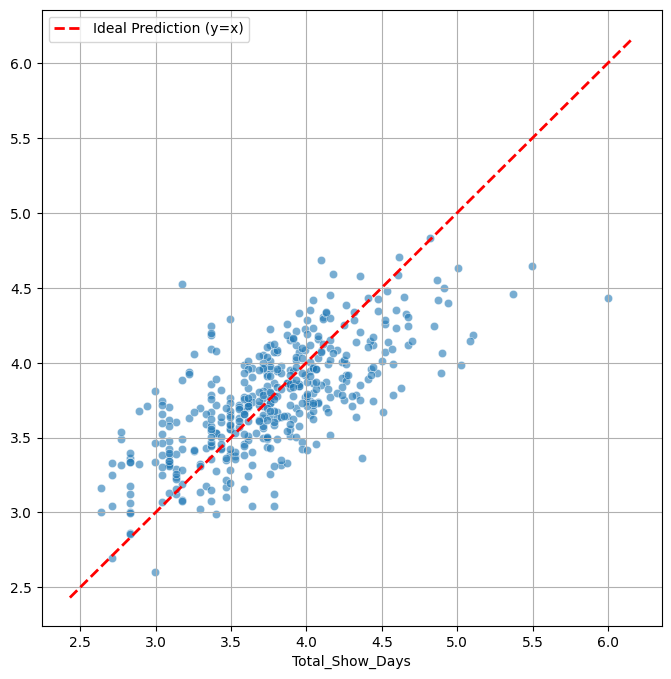

In [25]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6) 

min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
margin = (max_val - min_val) * 0.05
plot_range = np.linspace(min_val - margin, max_val + margin, 100)

plt.plot(plot_range, plot_range, color='red', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')
plt.legend()
plt.grid(True)
plt.show()

# OLS - Total_Weeks

In [26]:
y_train = y_train_df["Total_Weeks"]
y_train = np.log1p(y_train)
y_test = y_test_df["Total_Weeks"]
y_test = np.log1p(y_test)

In [27]:
alphas = np.logspace(-3, 3, 100)

In [28]:
ridge_cv = RidgeCV(
    alphas=alphas, 
    cv=5, # 5-겹 교차 검증 사용
    scoring='neg_mean_squared_error' # MSE 최소화
)
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge)
ss_res_ridge_cv = np.sum((y_test - y_pred_ridge) ** 2)
ss_tot_ridge_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge_cv = 1 - ss_res_ridge_cv / ss_tot_ridge_cv
print("Optimal alpha (RidgeCV):", ridge_cv.alpha_)
print("MSE (RidgeCV):", mse_ridge_cv)
print("R^2 (RidgeCV):", r_squared_ridge_cv)

Optimal alpha (RidgeCV): 2.4770763559917115
MSE (RidgeCV): 0.09752253685612518
R^2 (RidgeCV): 0.4579778265864445


In [29]:
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5, 
    random_state=42,
    max_iter=10000 # 수렴을 위해 반복 횟수 증가
)
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
ss_res_lasso_cv = np.sum((y_test - y_pred_lasso_cv) ** 2)
ss_tot_lasso_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv.alpha_)
print("MSE (LassoCV):", mse_lasso_cv)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.001
MSE (LassoCV): 0.10412490586632961
R^2 (LassoCV): 0.4212824070869614


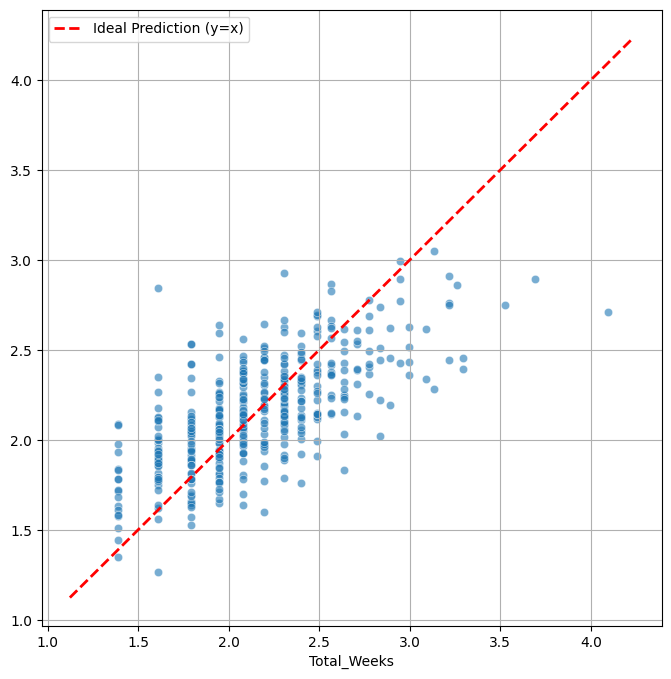

In [30]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6) 

min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
margin = (max_val - min_val) * 0.05
plot_range = np.linspace(min_val - margin, max_val + margin, 100)

plt.plot(plot_range, plot_range, color='red', linestyle='--', linewidth=2, label='Ideal Prediction (y=x)')
plt.legend()
plt.grid(True)
plt.show()